In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv


In [15]:
!pip install nltk

In [16]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [17]:
path = '/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv'
data = pd.read_csv(path)
data.head(10)

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
5,7925,MaddenNFL,Positive,Thank you @EAMaddenNFL!! \n\nNew TE Austin Hoo...
6,11332,TomClancysRainbowSix,Positive,"Rocket League, Sea of Thieves or Rainbow Six: ..."
7,1107,AssassinsCreed,Positive,my ass still knee-deep in Assassins Creed Odys...
8,2069,CallOfDuty,Negative,FIX IT JESUS ! Please FIX IT ! What In the wor...
9,3185,Dota2,Positive,The professional dota 2 scene is fucking explo...


In [18]:
data.columns = ['NUM','COMPANEY','SENTIMENT','TWEET']
data.head()

,NUM,COMPANEY,SENTIMENT,TWEET
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [19]:
data = data.drop(['NUM','COMPANEY'],axis = 1)
data.head(10)

,SENTIMENT,TWEET
0,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,Negative,@Microsoft Why do I pay for WORD when it funct...
2,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,Neutral,Now the President is slapping Americans in the...
4,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
5,Positive,Thank you @EAMaddenNFL!! \n\nNew TE Austin Hoo...
6,Positive,"Rocket League, Sea of Thieves or Rainbow Six: ..."
7,Positive,my ass still knee-deep in Assassins Creed Odys...
8,Negative,FIX IT JESUS ! Please FIX IT ! What In the wor...
9,Positive,The professional dota 2 scene is fucking explo...


In [20]:
relevant_labels = ['Negative', 'Neutral', 'Positive']  # Update this list with your relevant labels
data = data[data['SENTIMENT'].apply(lambda sentiment: sentiment in relevant_labels)]
data['SENTIMENT'].value_counts

<bound method IndexOpsMixin.value_counts of 0       Neutral
1      Negative
2      Negative
3       Neutral
4      Negative
         ...   
992    Negative
993    Positive
996    Positive
997    Positive
998     Neutral
Name: SENTIMENT, Length: 828, dtype: object>

In [21]:
# Preprocessing steps
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

import string

def preprocess_text(text):
    # Tokenization and removal of stopwords, punctuation, and special characters
    words = nltk.word_tokenize(text)
    words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
    words = [word for word in words if word not in string.punctuation and not word.isdigit()]
    return ' '.join(words)


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:
data['TWEET']  = data['TWEET'].apply(preprocess_text)
data['TWEET'].head(10)

0    bbc news amazon boss jeff bezos rejects claims...
1    microsoft pay word functions poorly samsungus ...
2    csgo matchmaking full closet hacking truly awf...
3    president slapping americans face really commi...
4    hi eahelp madeleine mccann cellar past years l...
5    thank eamaddennfl new te austin hooper orange ...
6    rocket league sea thieves rainbow six love pla...
7    ass still assassins creed odyssey way anytime ...
8    fix jesus please fix world going playstation a...
9    professional dota scene fucking exploding comp...
Name: TWEET, dtype: object

In [23]:
unique_words = set()
for sentence in data['TWEET']:
    words = sentence.split()
    unique_words.update(words)
num_unique_words = len(unique_words)
print(f"Number of Unique Words: {num_unique_words}")

Number of Unique Words: 3727


In [24]:
# Define X and y
X = data['TWEET']
y = data['SENTIMENT']

# Tokenize and pad sequences
max_words = 5000  # Adjust as needed
max_len = 50  # Adjust as needed

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=max_len)
print(y.shape)

(828,)


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# # Convert string labels to integer labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# # One-hot encode the integer labels
y_train_encoded = to_categorical(y_train_encoded, num_classes = 3)  # Assuming 3 classes (negative, neutral, positive)
y_test_encoded = to_categorical(y_test_encoded, num_classes=3)
print(y_train_encoded.shape,y_test_encoded.shape)

(662, 3) (166, 3)


In [40]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout,SpatialDropout1D
from tensorflow.keras.models import Sequential

embed_dim = 128
lstm_out = 196
max_fatures = 2000

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 128)           256000    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 50, 128)          0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 196)               254800    
                                                                 
 dense_1 (Dense)             (None, 3)                 591       
                                                                 
Total params: 511,391
Trainable params: 511,391
Non-trainable params: 0
_________________________________________________________________
None


In [41]:
y_train_indices = np.argmax(y_train_encoded, axis=1)
y_test_indices = np.argmax(y_test_encoded,axis=1)

In [42]:
print(f'Xtrain shape{X_train.shape},Ytrain encoded{y_train_encoded.shape}')

Xtrain shape(662, 50),Ytrain encoded(662, 3)


In [43]:
batch_size = 60   # Adjust as needed
epochs = 15  # Adjust as needed

history = model.fit(X_train, y_train_encoded, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15
10/10 [==============================] - 11s 425ms/step - loss: 1.0965 - accuracy: 0.3244 - val_loss: 1.0886 - val_accuracy: 0.4179
Epoch 2/15
10/10 [==============================] - 4s 406ms/step - loss: 1.0716 - accuracy: 0.4252 - val_loss: 1.0772 - val_accuracy: 0.4179
Epoch 3/15
10/10 [==============================] - 5s 470ms/step - loss: 1.0278 - accuracy: 0.4420 - val_loss: 1.0264 - val_accuracy: 0.4776
Epoch 4/15
10/10 [==============================] - 5s 475ms/step - loss: 0.9216 - accuracy: 0.6034 - val_loss: 1.0174 - val_accuracy: 0.4776
Epoch 5/15
10/10 [==============================] - 3s 342ms/step - loss: 0.8127 - accuracy: 0.6840 - val_loss: 0.9638 - val_accuracy: 0.5522
Epoch 6/15
10/10 [==============================] - 4s 366ms/step - loss: 0.6949 - accuracy: 0.7748 - val_loss: 0.9643 - val_accuracy: 0.6866
Epoch 7/15
10/10 [==============================] - 3s 300ms/step - loss: 0.5528 - accuracy: 0.8622 - val_loss: 0.9789 - val_accuracy: 0.6119
Epoch

In [ ]:
print(f'datatype of xtrain {type(X_train)}, datatype of y_train {type(y_train)}')
print(f'datatype of X_train {type(X_train)}, datatype of y_train {type(y_train)}')

In [45]:
# Evaluate the model on the test set
y_test_indices = np.argmax(y_test_encoded,axis=1)
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f'Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}')


6/6 [==============================] - 0s 14ms/step - loss: 1.2448 - accuracy: 0.5964
Test loss: 1.2448, Test accuracy: 0.5964


6/6 [==============================] - 0s 13ms/step


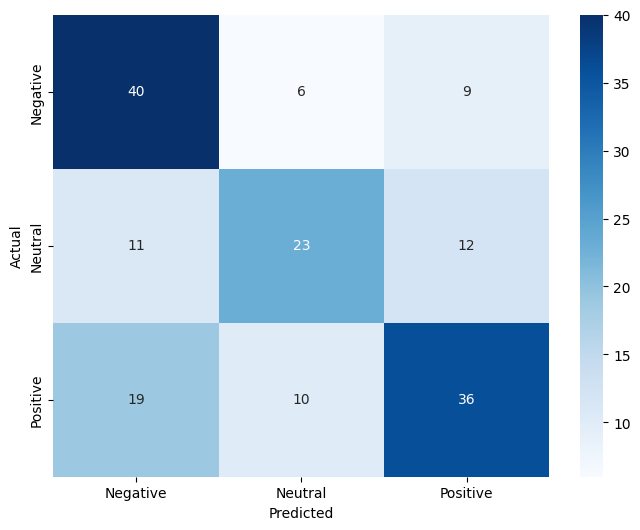

              precision    recall  f1-score   support

    Negative       0.57      0.73      0.64        55
     Neutral       0.59      0.50      0.54        46
    Positive       0.63      0.55      0.59        65

    accuracy                           0.60       166
   macro avg       0.60      0.59      0.59       166
weighted avg       0.60      0.60      0.59       166



In [48]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions
y_pred = model.predict(X_test)
y_pred_indices = np.argmax(y_pred, axis=1)

# Convert ground truth labels from one-hot encoding to indices
y_test_indices = np.argmax(y_test_encoded, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_test_indices, y_pred_indices)

# Plot the confusion matrix
class_names = ['Negative', 'Neutral', 'Positive']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print classification report
print(classification_report(y_test_indices, y_pred_indices, target_names=class_names))


In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load and preprocess your data (X_train, y_train)

# Convert string labels to integer labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Define a function to create your Keras model
def create_model(optimizer='adam', dropout_rate=0.0, hidden_units=128):
    model = Sequential()
    # Add your layers here
    model.add(Dense(hidden_units, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation='softmax'))  # Assuming 3 classes
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Create a KerasClassifier for use in scikit-learn's GridSearchCV
model = KerasClassifier(build_fn=create_model, verbose=0)

# Define hyperparameters and their possible values for grid search
param_grid = {
    'batch_size': [16, 32],
    'epochs': [10, 20],
    'optimizer': ['adam', 'sgd'],
    'dropout_rate': [0.0, 0.2],
    'hidden_units': [64, 128]
}

# Create GridSearchCV instance
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)

# Perform grid search
grid_result = grid.fit(X_train, y_train_encoded)

# Print best hyperparameters
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Evaluate the model with the best hyperparameters on the test set
best_model = grid_result.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Print classification report
class_names = ['Negative', 'Neutral', 'Positive']
print(classification_report(y_test, y_pred_labels, target_names=class_names))

In [49]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import make_scorer, f1_score

# Define your LSTM model as a function
def create_lstm_model(units=100, dropout_rate=0.2, optimizer='adam'):
    model = Sequential()
    model.add(Embedding(max_words, embedding_dim, input_length=max_len))
    model.add(LSTM(units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Create a KerasClassifier based on your model function
model = KerasClassifier(build_fn=create_lstm_model, verbose=0)

# Define hyperparameters to tune
param_grid = {
    'units': [50, 100, 150],
    'dropout_rate': [0.2, 0.3, 0.4],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [32, 64]
}

# Define custom scoring function (e.g., F1-score)
scorer = make_scorer(f1_score, average='weighted')

# Create GridSearchCV instance
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorer, cv=3, verbose=1, n_jobs=-1)

# Fit the grid search to your data
grid_result = grid.fit(X_train, y_train_encoded)

# Print the best parameters and their corresponding score
print("Best parameters found: ", grid_result.best_params_)
print("Best F1-score: {:.4f}".format(grid_result.best_score_))


Fitting 3 folds for each of 36 candidates, totalling 108 fits


/tmp/ipykernel_28/926466984.py:23: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_lstm_model, verbose=0)
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-09-13 05:34:00.839551: F tensorflow/tsl/platform/statusor.cc:33] Attempting to fetch value instead of handling error INTERNAL: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: fai

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGABRT(-6)}